<a href="https://colab.research.google.com/github/jianlgler/IST_labiagi/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessari 

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #per i gradient descent
#image load n display
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms #PIL img into tensors
import torchvision.models as models #trail/load pretrained models

import copy #deep copy of a model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Le immagini PIL da caricare hanno valori fra 0 e 255, ma noi le normalizziamo fra 0 e 1 rendendoli dei tensori. Devono inoltre essere resizate per avere la stessa dimensione. Se si lasciamo con valori compresi fra 0 e 255 le feature map non riusciranno a lavorare, a differenza della rete preallenata nella libreria Caffe, che invece è allenata sui tensori 0-255

In [3]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([transforms.Resize(imsize),  transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0) #fit into network's input dimension
  return image.to(device, torch.float)

style_img = image_loader("./sample_data/images/picasso.jpg")
content_img = image_loader("./sample_data/images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Funzioni per riconvertire i tensori in PIL img e visualizzarle

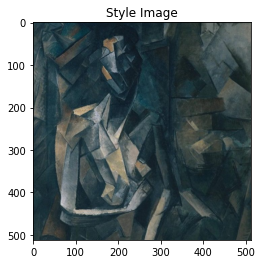

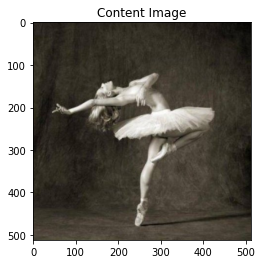

In [4]:
unloader = transforms.ToPILImage()

plt.ion() #interactive mode

def imshow(tensor, title=None):
  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

LOSS FUNCTIONS

Iniziamo dalla ContentLoss: distanza pesata del contenuto in un layer. La funzione prende in ingresso la feature map che processa l'input X e ritorna la distanza pesata. La feature map della content image deve essere nota alla funzione al momento del calcolo per ottenere la distanza. Implementiamo la funzione come un modulo torch con un costruttore che prende appunto quest'ultima feature map come input. La distanza, la mean square error, può essere chiamata tramite nn.MSELoss

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Important detail**: although this module is named ContentLoss, it is not a true PyTorch Loss function. If you want to define your content loss as a PyTorch Loss function, you have to create a PyTorch autograd function to recompute/implement the gradient manually in the backward method.

StyleLoss: il modulo è implementato simile a quello del content loss. Per calcolare la loss bisogna calcolarsi la Gram matrix, che si ottiene moltiplicando la matrice data per la sua trasposta. In questa applicazione la matrice che si pone è una reshaped version della feature map dell'input X del layer L. Le dimensioni sono KxN, dove K è il numero di feature maps in L e N è la lunghezza di ogni feature map vettorizzata in quel layer. Per far chiarezza, la prima linea della feature map reshapeata corrisponde alla prima feature map vettorizzata del layer 1. 

Infine bisogna normalizzare la gram matrix dividendo ogni elemento per il numero totale di elementi nella matrice. Questo ci evita di incappare in picchi di valori, soprattutto per matrici di larghe dimensioni. Altrimenti succederebbe che i primi layer, prima del pooling, avrebbero un maggior impatto durante il gradient descent. Le feature di stile tendono a stare nei layer più profondi, dunque questa normalizzazione è indubbiamente necessaria.

In [6]:
def gram_matrix(input):
  a, b, c, d = input.size() # a = batch size(=1)
  # b = number of feature maps
  # (c,d)=dimensions of a f. map (N=c*d)
  features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
  G = torch.mm(features, features.t())  # compute the gram product
  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
#molto simile al modulo content loss
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

IMPORTING A MODEL
Importiamo, seguendo il paper, la VGG-19, preallenata.
La sua implementazione in PyTorch è difisa in due Sequential child: **features** (con and pool layers) e **classifier** (con i fully connected layers). Attenendoci sempre al paper teniamo semplicemente il modulo *features*
poichè ci serviremo dell'output del layer di convoluzione individuale per misurare le loss del contenuto e dello stile. Alcuni layer in training e in evaluation si comportando differentemente, e dunque bisogna settare la network su "evaluation mode" usando .eval(). 

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Ricordarsi che la vgg lavora con canali normalizzati da mean=[0.485, 0.456, 0.406] e std=[0.229, 0.224, 0.225]. Utilizzeremo gli stessi tensori per normalizzare le immagini prima di farle girare nella rete.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

#creiamo un modulo per normalizzare l'img in input così da poterla mettere in un nn.Sequential

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # .view the mean and std to make them [C x 1 x 1] so that they can
    # directly work with image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def formward(self, img):
    return (img - self.mean) / self.std

Un modulo sequential contiene una lista ordinata di moduli figlio allineati nel giusto ordine. Noi dobbiamo inserire i nostri layer content loss e style loss subito dopo le convoluzioni. Per fare ciò bisogna creare un nuovo Sequential con le loss correttamente inserite.

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4'] #ci atteniamo al paper, pagina 12 [PDF] dopo la formula della total_loss
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    #per mantenere un accesso iterabile o listare le loss
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0 #aumentiamo ogni volta che c'è una convoluzione
    for layer in cnn.children():
      if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
      else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

      model.add_module(name, layer) #aggiungiamo il layer

      if name in content_layers:
        #add content loss
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)